## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [18]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=1000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    traceLength=8,     # Number of steps each sampled episode should contain
    batchSize=4,     # Number of episodes sampled from experience buffer
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=4.0, noiseLevel=0.1),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=4.0, noiseLevel=0.1),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=4.0, noiseLevel=0.1),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='Test-Frequency-3-generators-abs_reward'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.1)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.2, gamma=0.00142), minPower=0.5, maxPower=4.0, noiseLevel=0.1), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=4.0, noiseLevel=0.1), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=4.0, noiseLevel=0.1)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=1000, maxSteps=100, traceLength=8, batchSize=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='Test-Frequency-3-generators-abs_reward')

Train Agents

In [6]:
def rewardFn(deltaFreq):
    baseComponent = 2**(-(deltaFreq**2)/100)
    peakComponent = 2**(-abs(deltaFreq)/2)
    earnedReward = baseComponent + 9*peakComponent

    return earnedReward, {'base': baseComponent, 'peak': 9*peakComponent, 'total':earnedReward}

In [7]:
from learning.frequency import ModelAdapterFrequency as ModelAdapter


In [8]:
%%time
modelAdapter = ModelAdapter(rewardFn=rewardFn)
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0915 19:01:29.592214 140018004395776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0915 19:01:29.593485 140018004395776 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0915 19:01:29.618453 140018004395776 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

agent G1: actor
agent G1: actor-target
  critic cost_freq_G1_critic: 1
  critic cost_freq_G1_critic: 2
  critic cost_freq_G1_critic: 3
  critic cost_freq_G1_critic: 4
  critic cost_freq_G1_critic: 5
  critic cost_freq_G1_critic: 6
  critic cost_freq_G1_critic: 7
  critic cost_freq_G1_critic: 8
agent G1: critic
  critic cost_freq_G1_critic_target: 1
  critic cost_freq_G1_critic_target: 2
  critic cost_freq_G1_critic_target: 3
  critic cost_freq_G1_critic_target: 4
  critic cost_freq_G1_critic_target: 5
  critic cost_freq_G1_critic_target: 6
  critic cost_freq_G1_critic_target: 7
  critic cost_freq_G1_critic_target: 8
agent G1: critic-target
agent G2: actor
agent G2: actor-target
  critic cost_freq_G2_critic: 1
  critic cost_freq_G2_critic: 2
  critic cost_freq_G2_critic: 3
  critic cost_freq_G2_critic: 4
  critic cost_freq_G2_critic: 5
  critic cost_freq_G2_critic: 6
  critic cost_freq_G2_critic: 7
  critic cost_freq_G2_critic: 8
agent G2: critic
  critic cost_freq_G2_critic_target: 1
 

In [9]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

agent G1: actor
agent G1: actor-target
  critic cost_freq_G1_critic: 1
  critic cost_freq_G1_critic: 2
  critic cost_freq_G1_critic: 3
  critic cost_freq_G1_critic: 4
  critic cost_freq_G1_critic: 5
  critic cost_freq_G1_critic: 6
  critic cost_freq_G1_critic: 7
  critic cost_freq_G1_critic: 8
agent G1: critic
  critic cost_freq_G1_critic_target: 1
  critic cost_freq_G1_critic_target: 2
  critic cost_freq_G1_critic_target: 3
  critic cost_freq_G1_critic_target: 4
  critic cost_freq_G1_critic_target: 5
  critic cost_freq_G1_critic_target: 6
  critic cost_freq_G1_critic_target: 7
  critic cost_freq_G1_critic_target: 8
agent G1: critic-target
agent G2: actor
agent G2: actor-target
  critic cost_freq_G2_critic: 1
  critic cost_freq_G2_critic: 2
  critic cost_freq_G2_critic: 3
  critic cost_freq_G2_critic: 4
  critic cost_freq_G2_critic: 5
  critic cost_freq_G2_critic: 6
  critic cost_freq_G2_critic: 7
  critic cost_freq_G2_critic: 8
agent G2: critic
  critic cost_freq_G2_critic_target: 1
 

W0915 19:54:29.660681 140018004395776 deprecation.py:323] From /home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

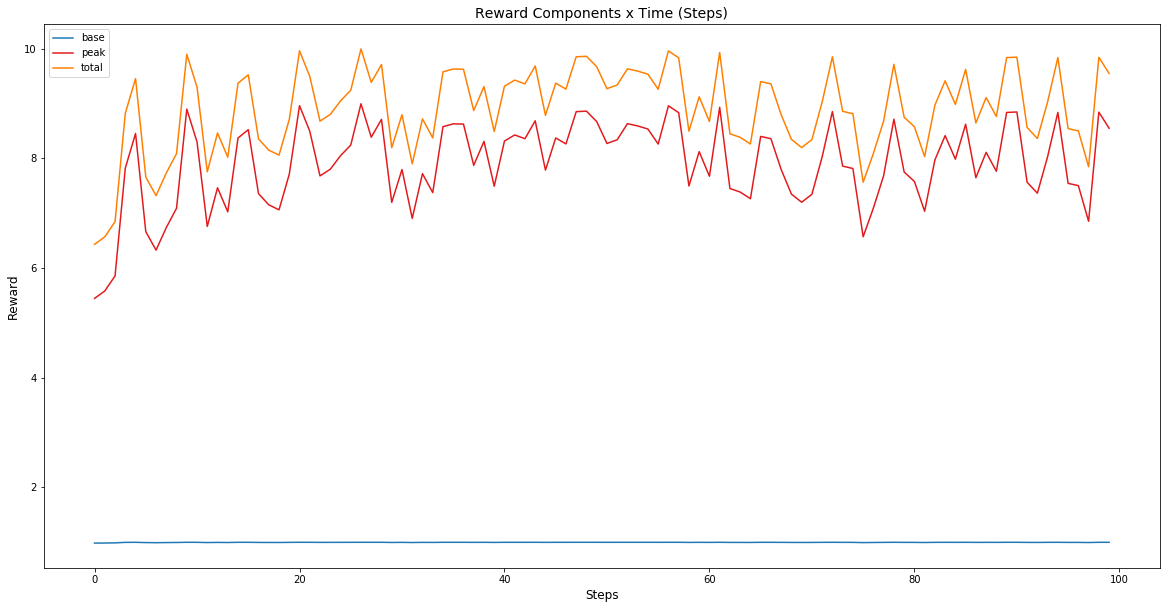

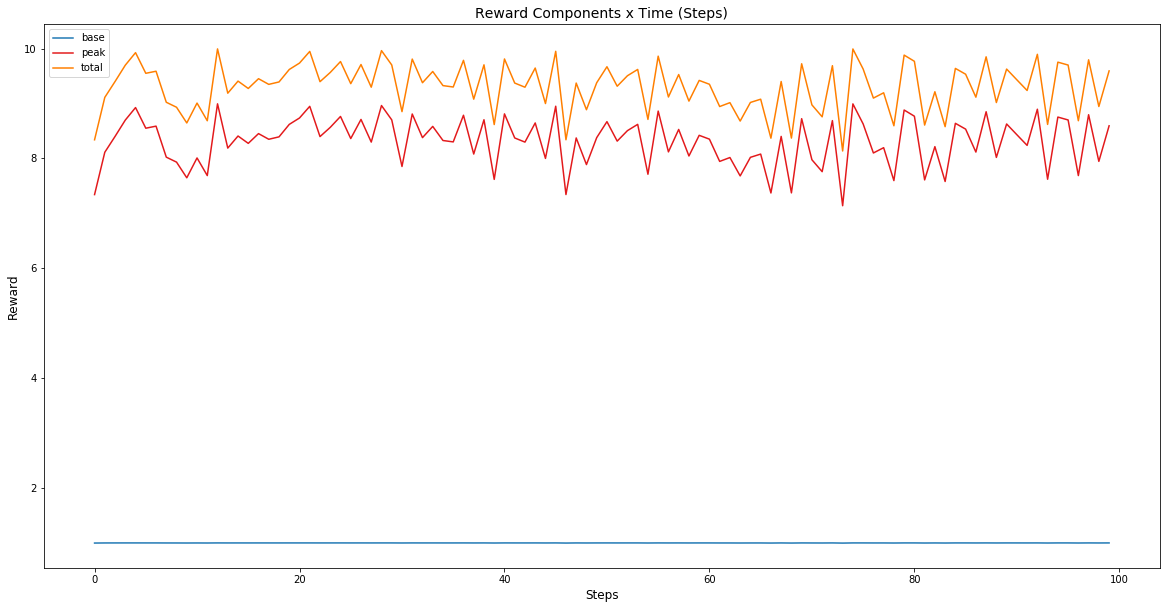

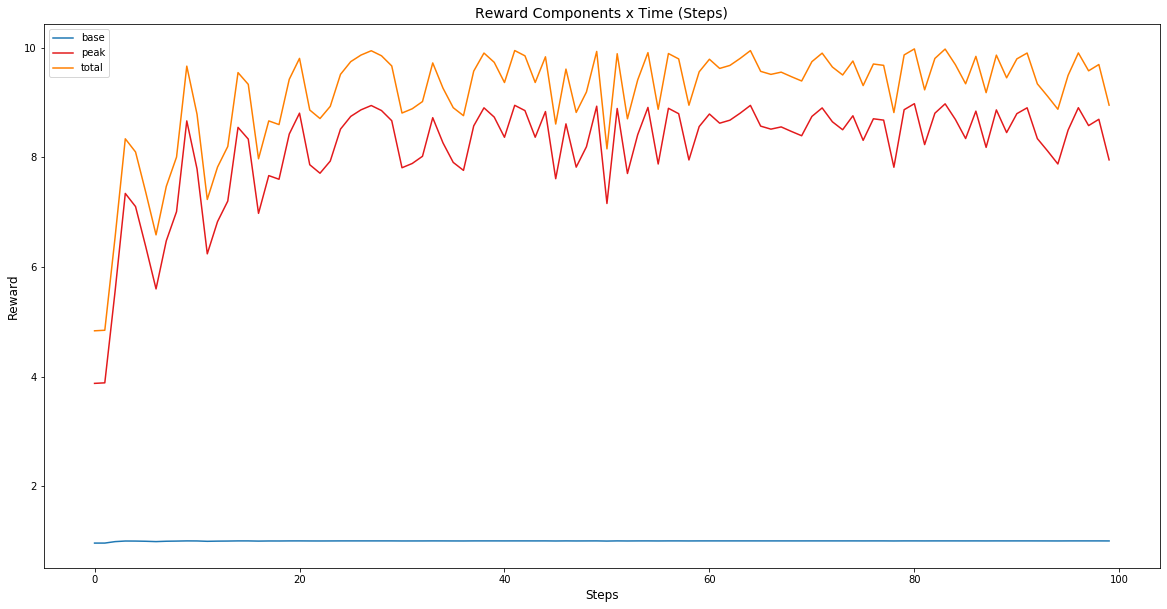

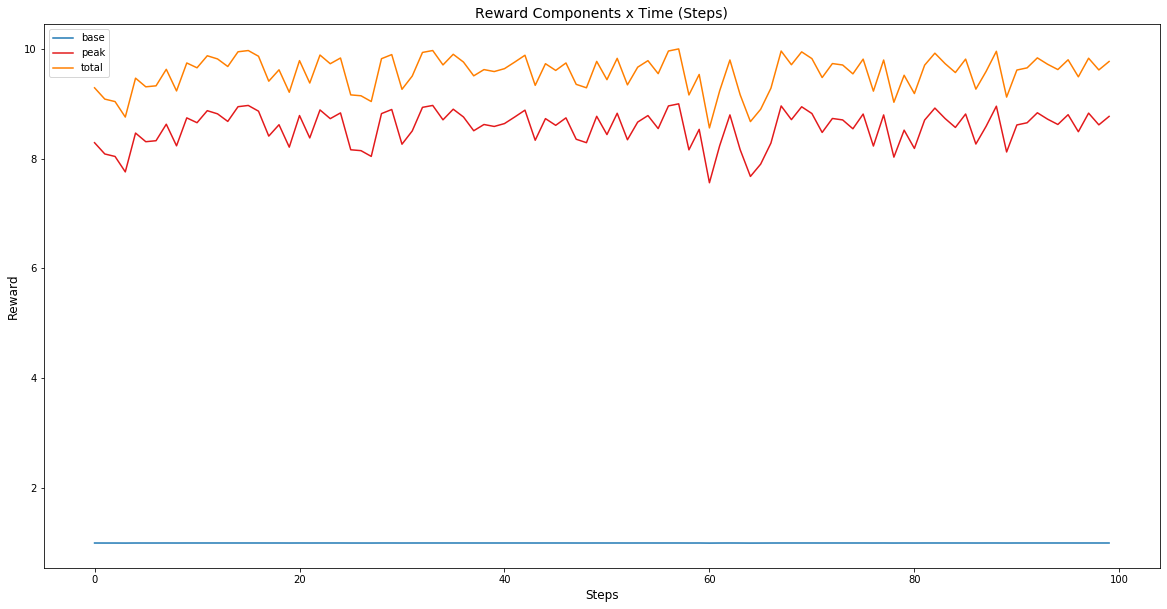

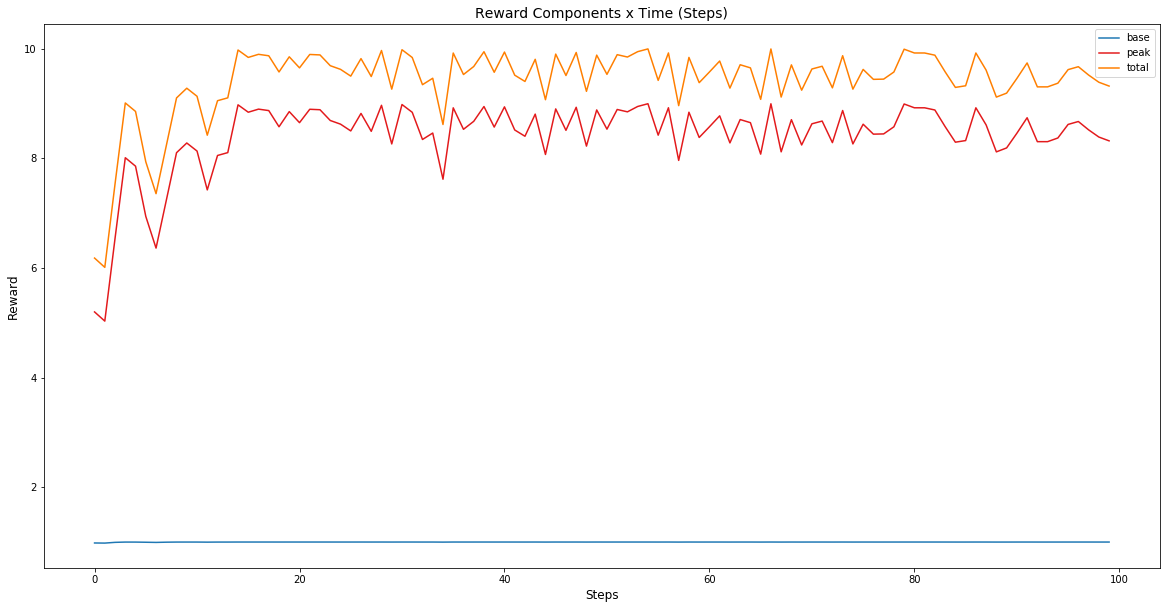

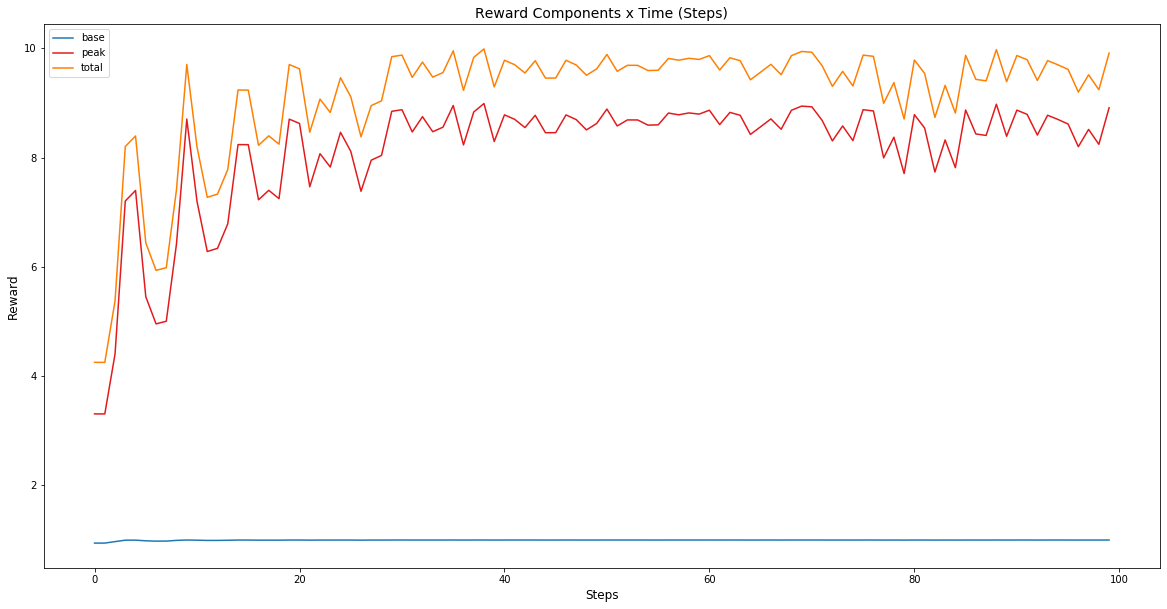

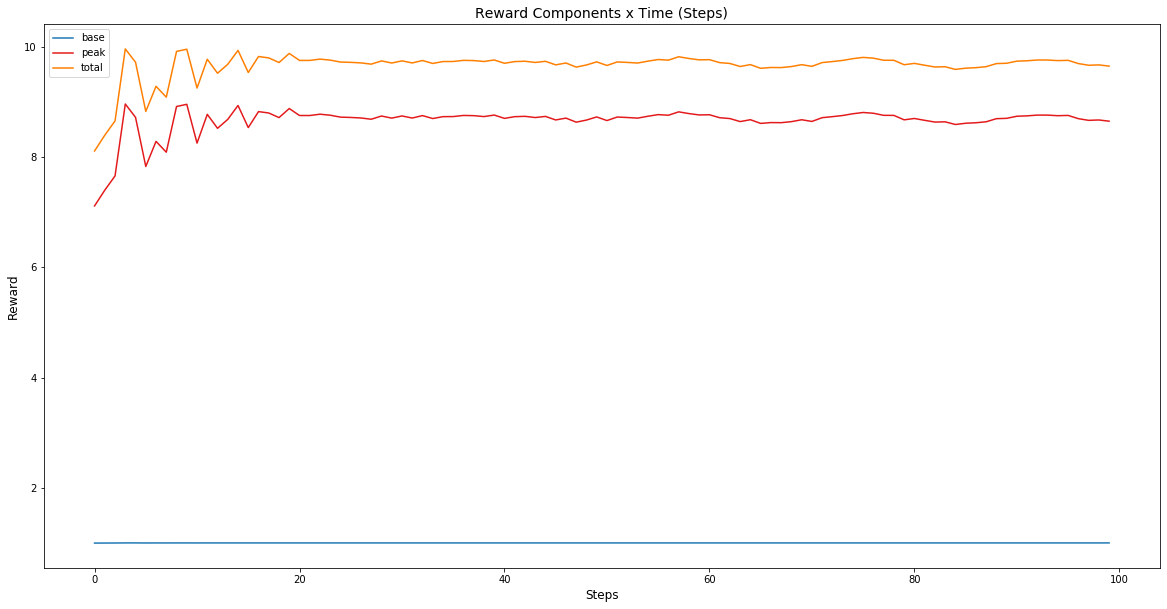

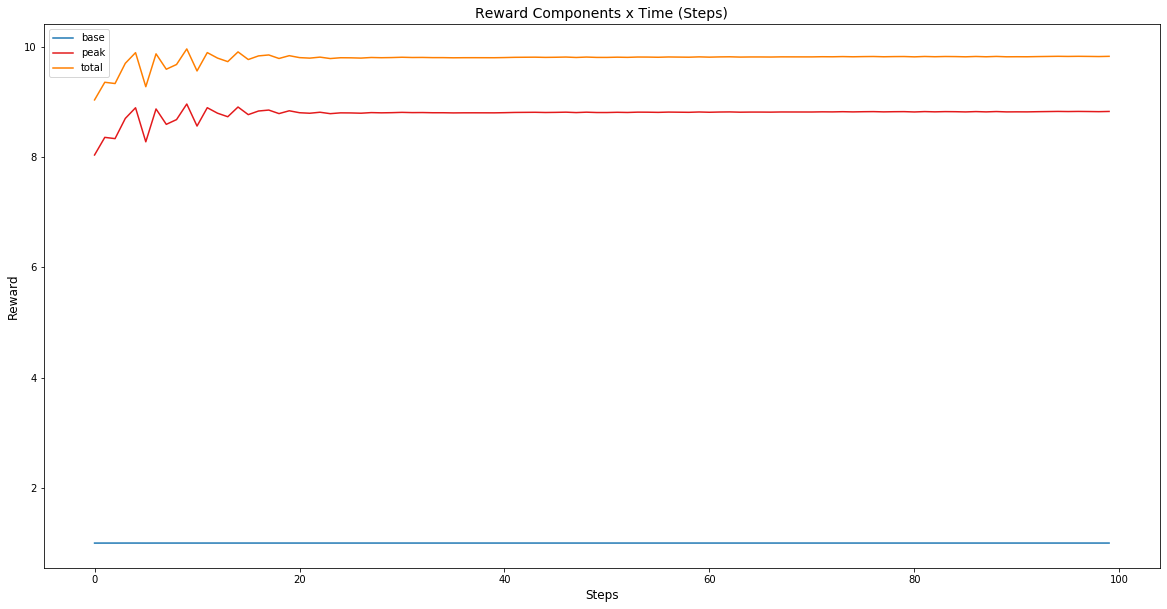

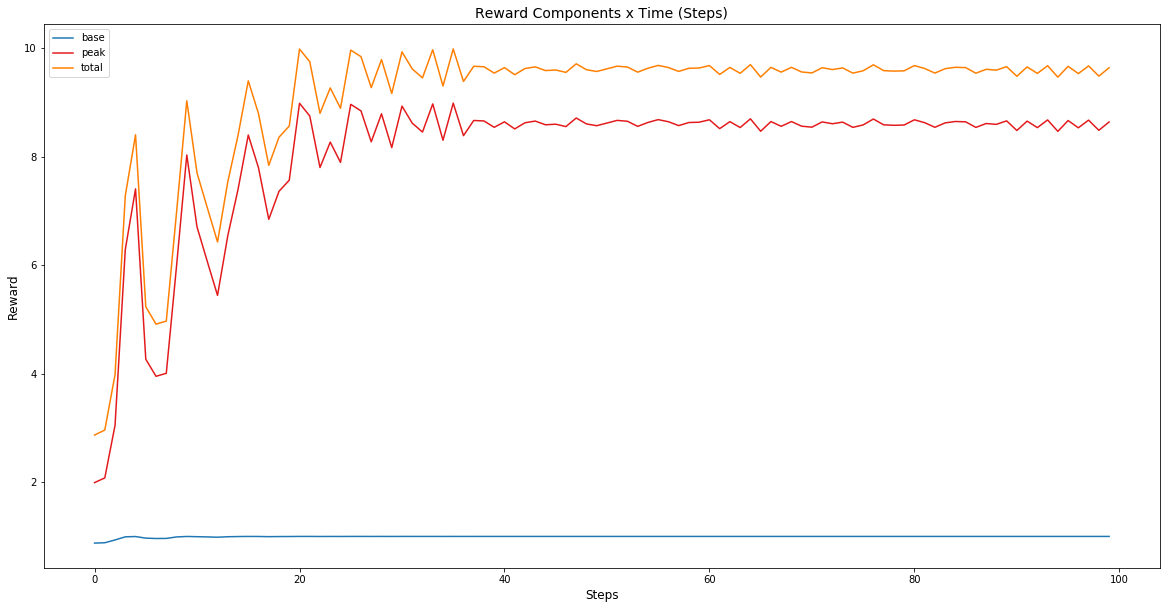

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2907.5305774591066

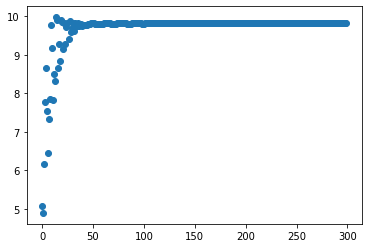

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

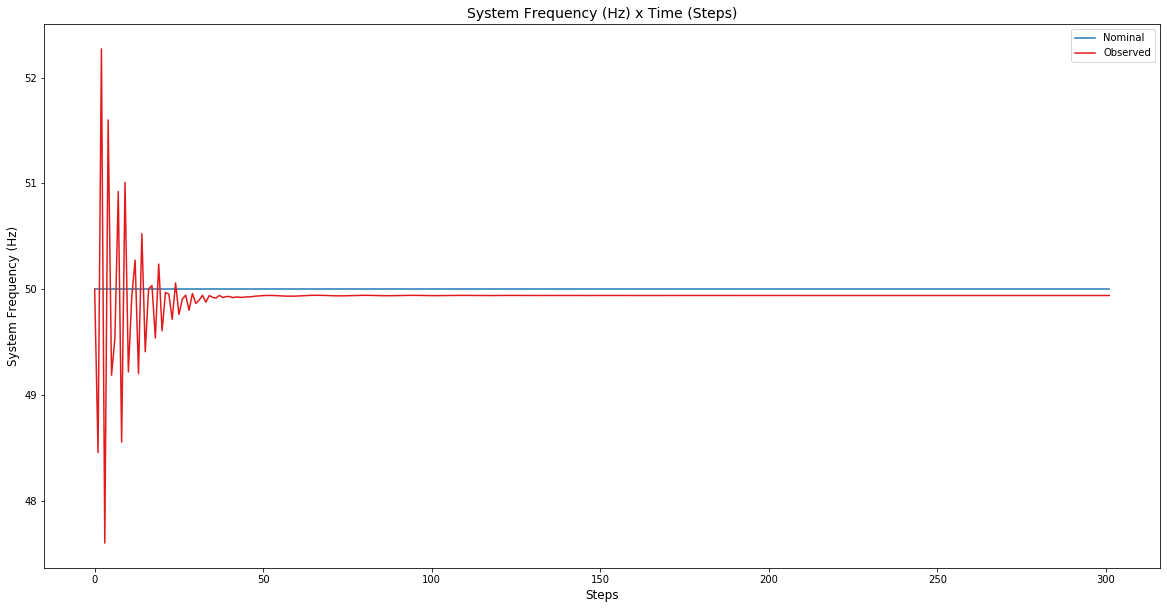

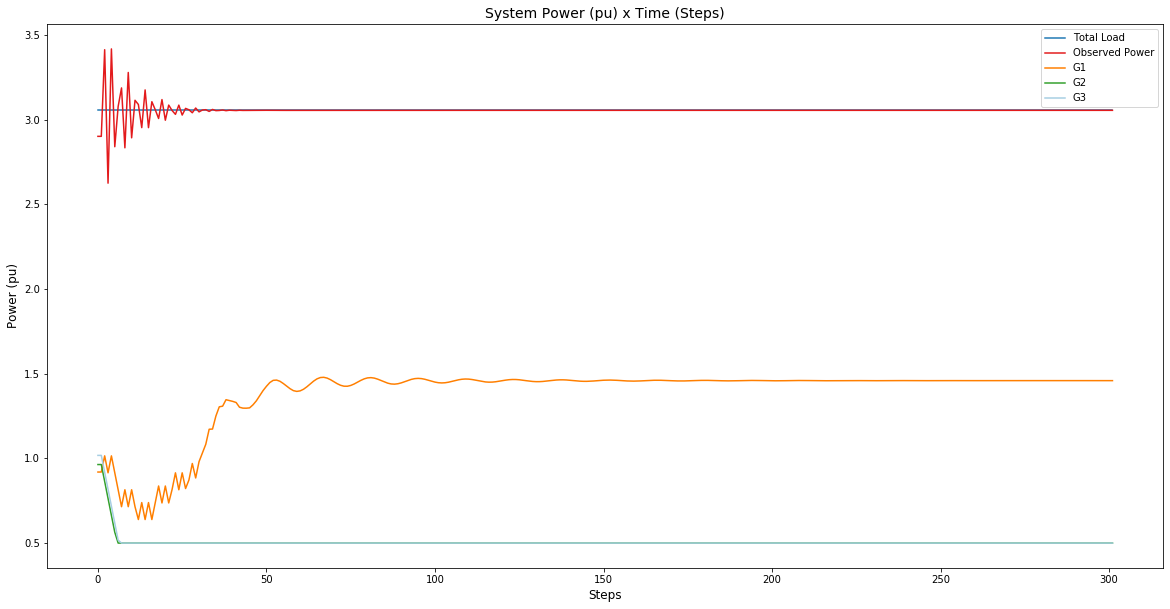

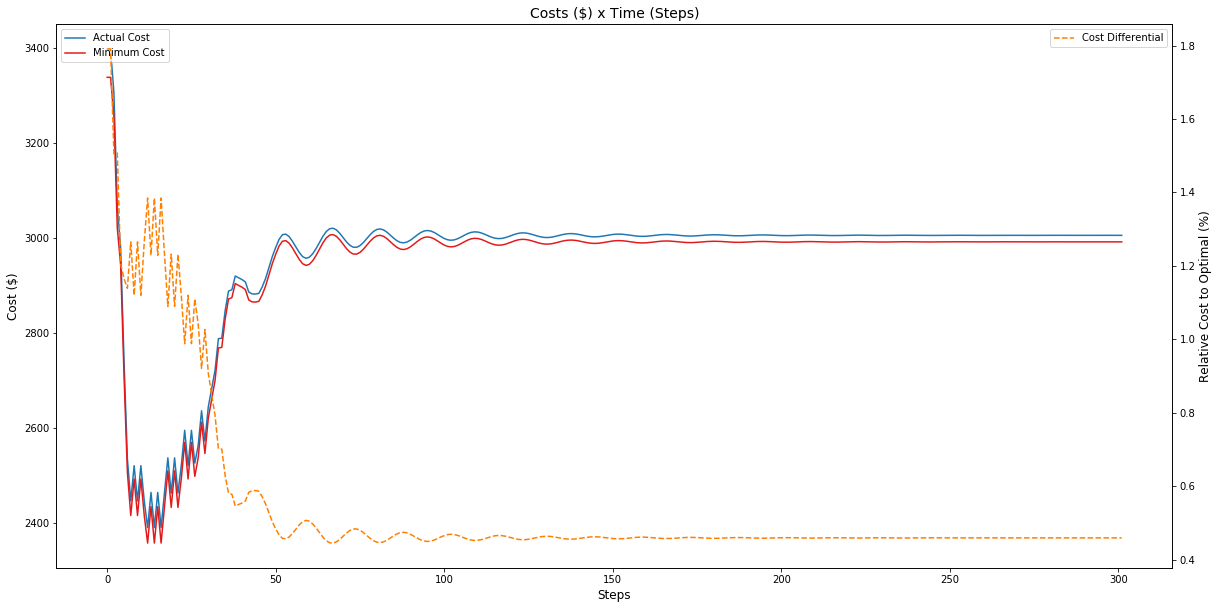

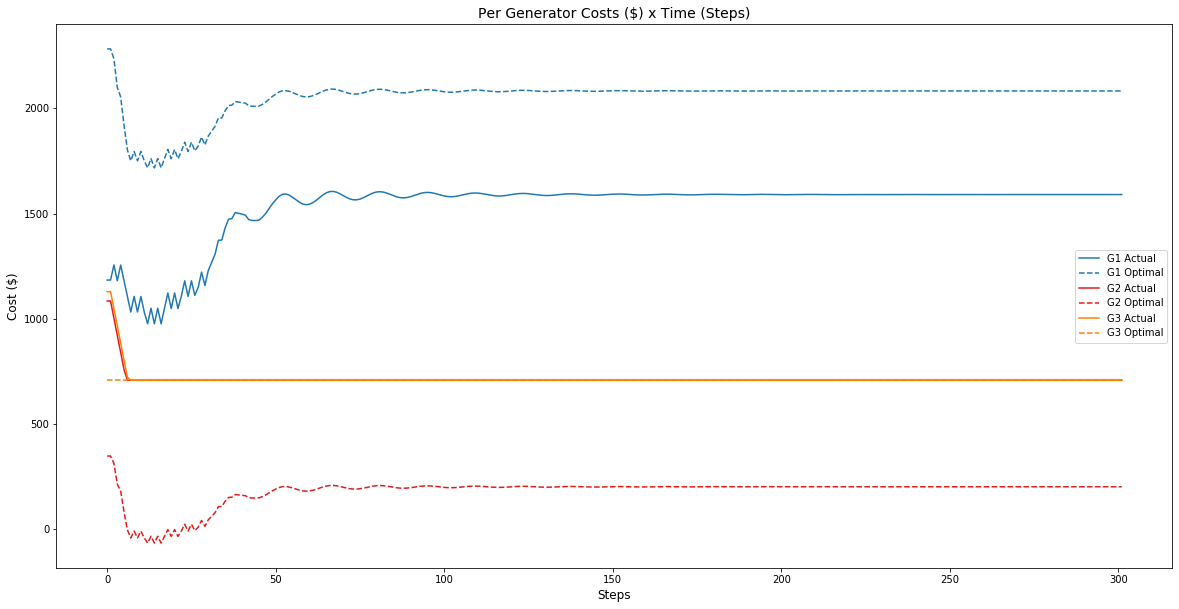

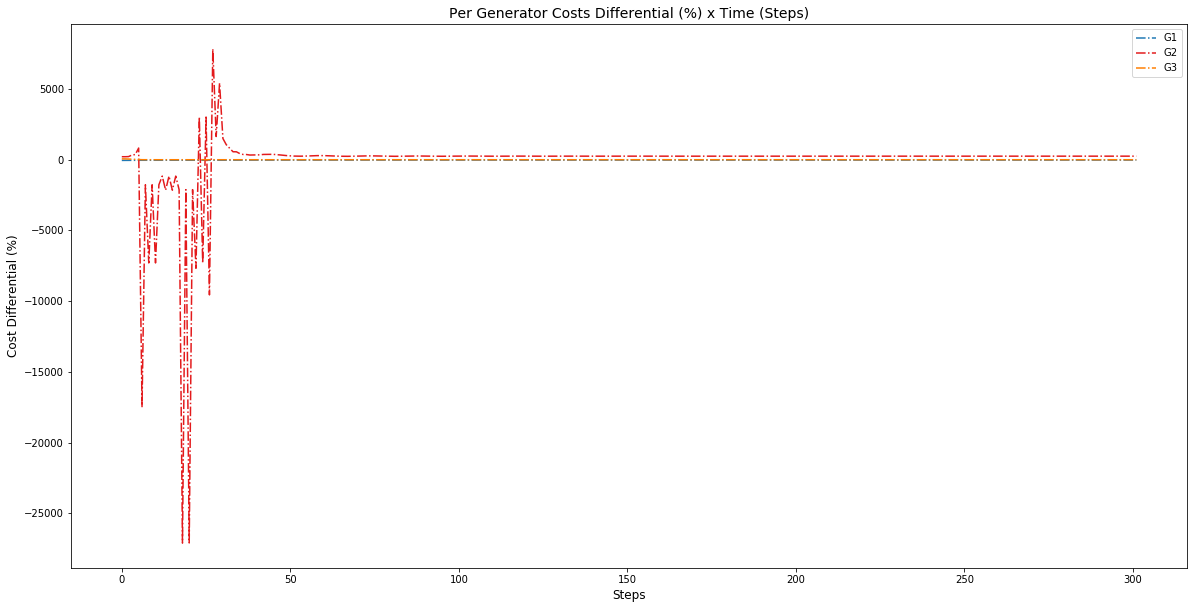

In [13]:
plotAll(electricalSystem.systemHistory)

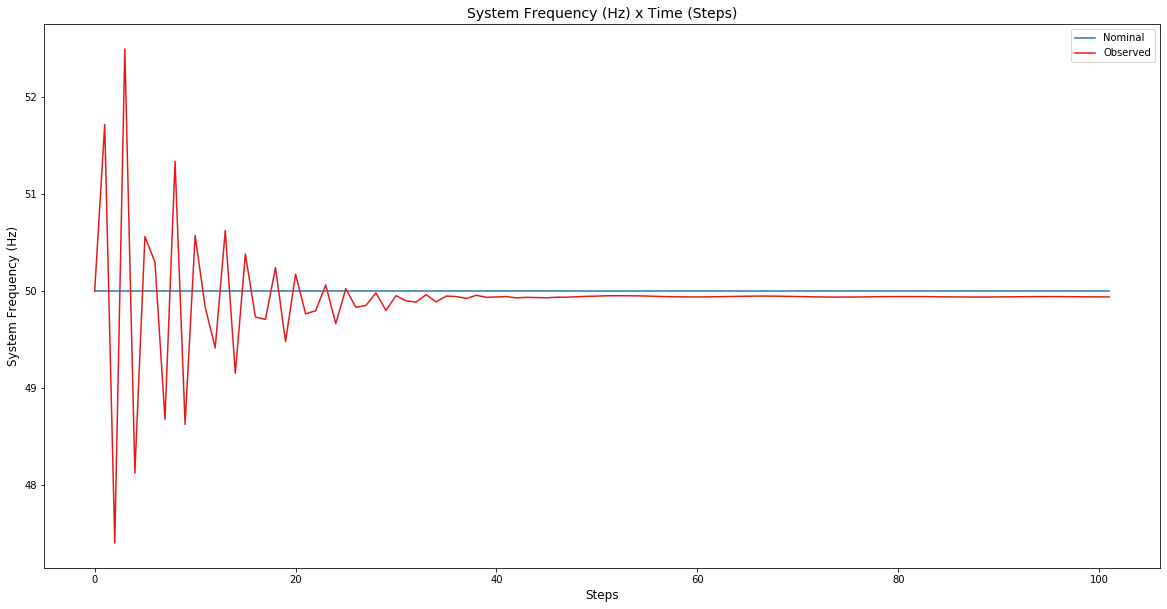

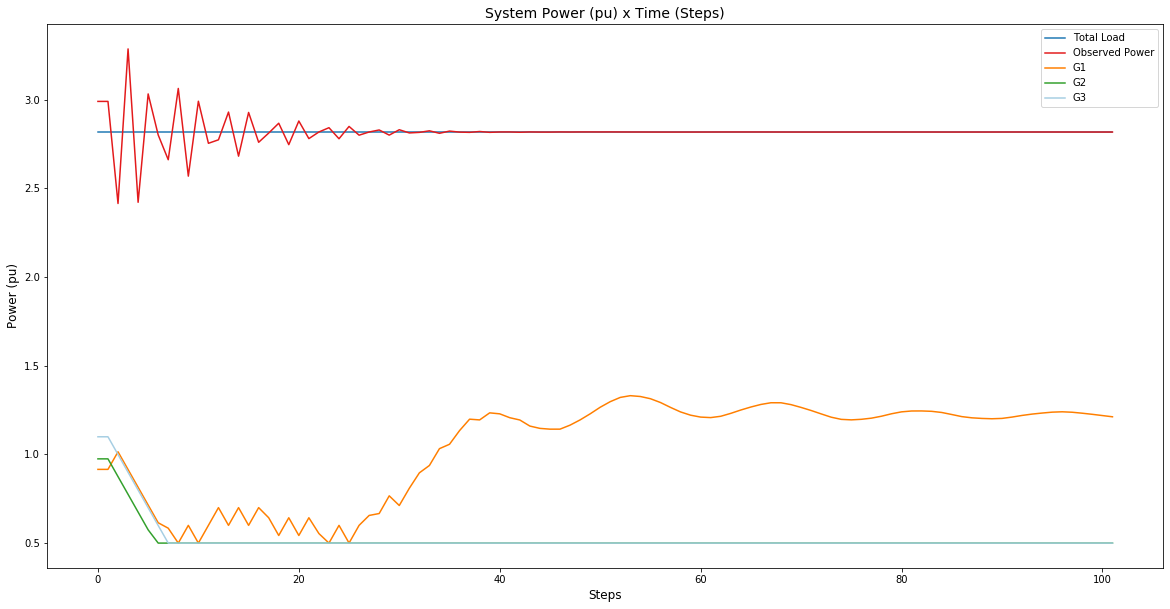

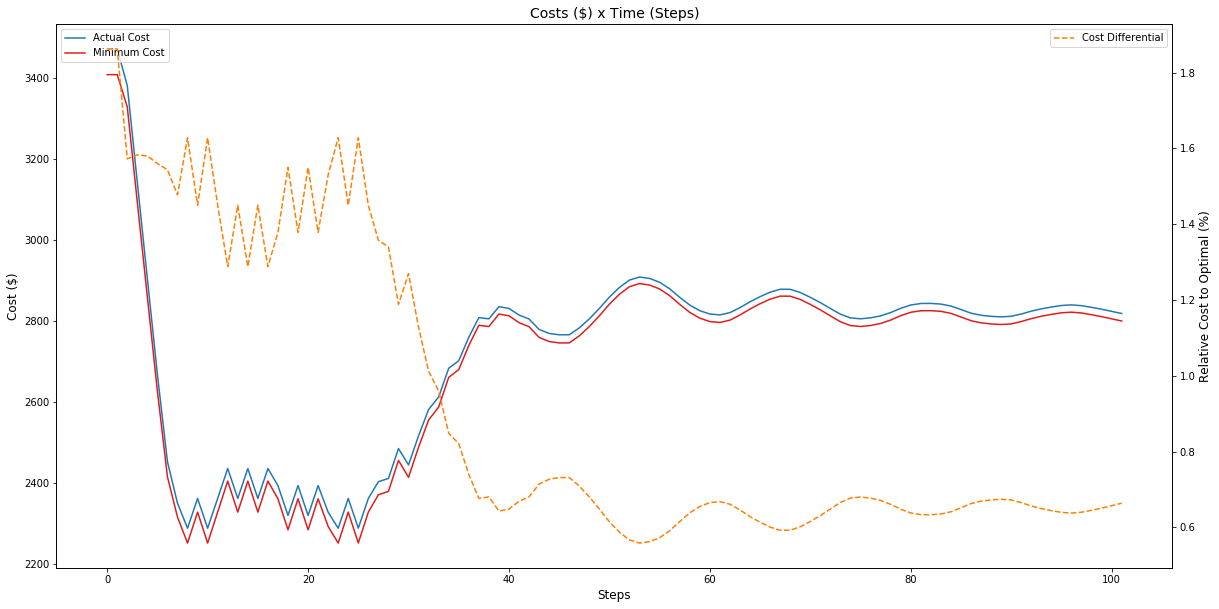

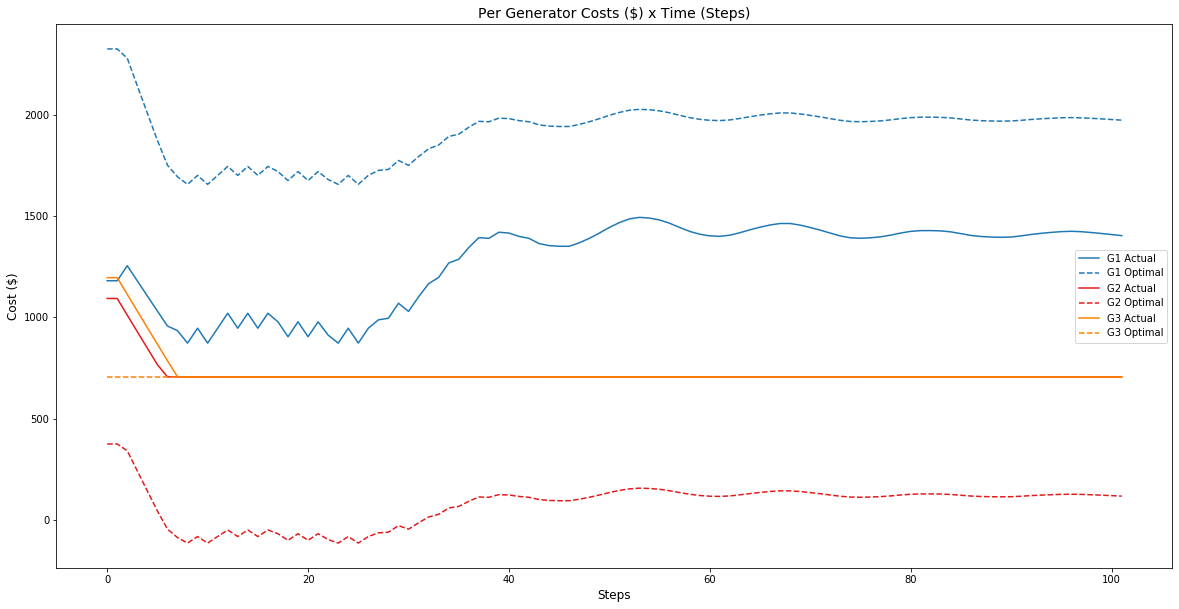

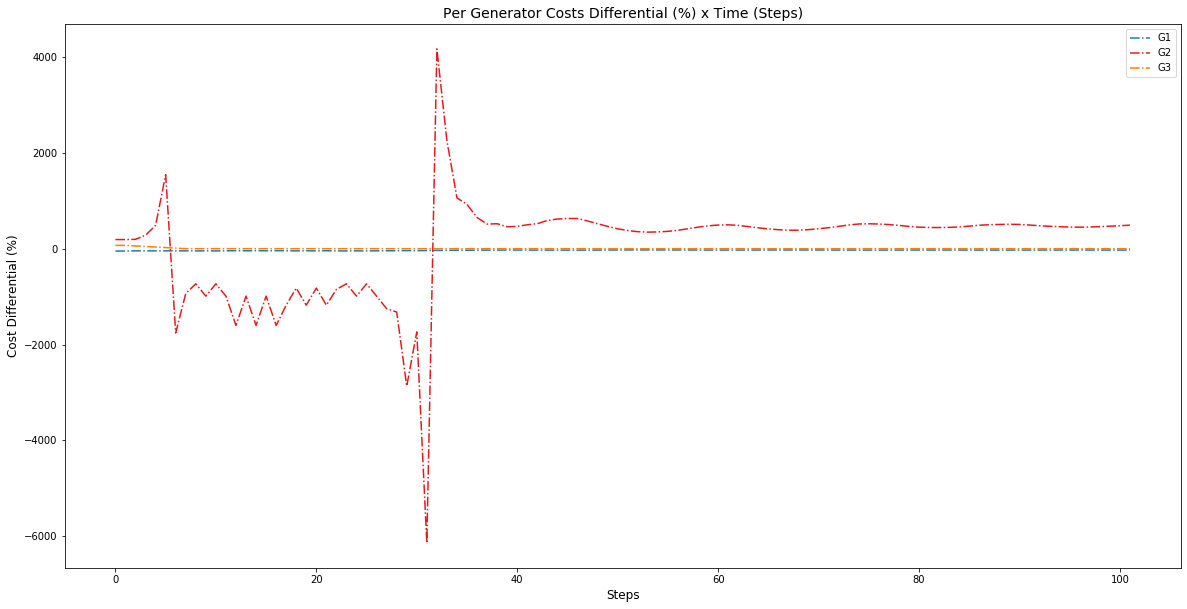

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'base': 0.9855497398648304,
   'peak': 5.4466393406105755,
   'total': 6.432189080475406},
  {'base': 0.986924243690217,
   'peak': 5.582559352079231,
   'total': 6.569483595769448},
  {'base': 0.9894003346393746,
   'peak': 5.8562259751809975,
   'total': 6.845626309820372},
  {'base': 0.9988657219369721,
   'peak': 7.82236216782401,
   'total': 8.821227889760982},
  {'base': 0.9997737831881555,
   'peak': 8.453755868873023,
   'total': 9.453529652061178},
  {'base': 0.9948013330621802,
   'peak': 6.663800944582593,
   'total': 7.658602277644773},
  {'base': 0.9928614567032793,
   'peak': 6.327354249282427,
   'total': 7.3202157059857065},
  {'base': 0.995175090955643,
   'peak': 6.737723759600097,
   'total': 7.73289885055574},
  {'base': 0.9967228681197402,
   'peak': 7.090287508927766,
   'total': 8.087010377047505},
  {'base': 0.9999924288823329,
   'peak': 8.89750062969732,
   'total': 9.897493058579652},
  {'base': 0.9996213427773273,
   'peak': 8.299647308150462,
   'total':

TypeError: float() argument must be a string or a number, not 'dict'

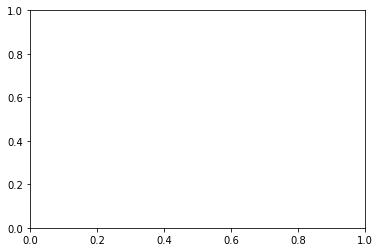

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()